In [22]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import argparse
import albumentations
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils as smp_utils
import torch
import torch.nn.functional as F
from tqdm import tqdm as tqdm
import sys
from torch.utils.data import DataLoader
import math
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
import glob
import rasterio
import json
import re
from skimage import measure
from shapely.geometry import shape
from rasterio.features import shapes

In [23]:
import matplotlib
import tqdm
import PIL
import skimage
import shapely

print(np.__version__)
print(cv2.__version__)
print(matplotlib.__version__)
print(albumentations.__version__)
print(smp.__version__)
print(torch.__version__)
print(tqdm.__version__)
print(PIL.__version__)
print(rasterio.__version__)
print(skimage.__version__)
print(shapely.__version__)

1.24.3
4.7.0
3.7.1
1.3.0
0.2.1
1.12.1+cpu
4.64.1
9.4.0
1.3.5.post1
0.19.3
1.8.4


In [26]:
!where python

C:\Users\m_waseem\Miniconda3\envs\BUN_GUI\python.exe
C:\Users\m_waseem\AppData\Local\Programs\Python\Python37\python.exe
C:\Users\m_waseem\Miniconda3\python.exe
C:\Program Files\QGIS 3.16.9\bin\python.exe


In [24]:
#//////////////////////// UTILITY FUNCTIONS \\\\\\\\\\\\\\\\\\\\\\\\

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        #print(image.shape)
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    
# helper function for creating RGB of ith mask
def MasktoRGB(mask,color):
    r = np.expand_dims((mask*color[0]),axis=-1)
    g = np.expand_dims((mask*color[1]),axis=-1)
    b = np.expand_dims((mask*color[2]),axis=-1)
    img = np.concatenate((r,g,b), axis=-1)
    return img.astype(int)

def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

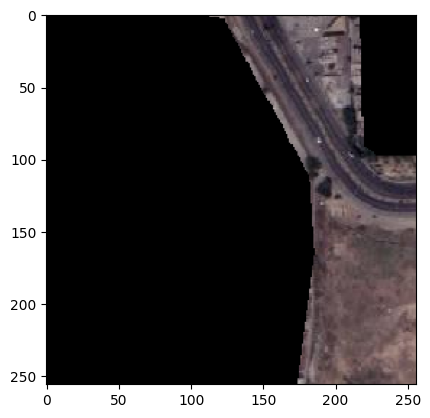

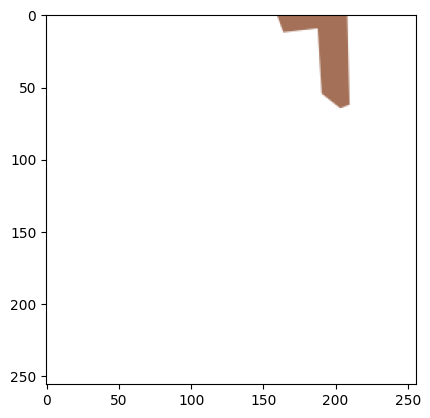

In [25]:
base_inp_path = r"D:\LUMS_RA\Data\Seg_data\Segmentation\combined_data(train_val)\images"
images = os.listdir(base_inp_path)
for file in images:
    img = cv2.cvtColor(cv2.imread(os.path.join(base_inp_path,file)), cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()
    mask = cv2.cvtColor(cv2.imread(os.path.join(base_inp_path.replace('images','masks'),file)), cv2.COLOR_BGR2RGB)
    plt.imshow(mask)
    plt.show()
    break

In [5]:
# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['built-up','background']
    colors = [
        (164, 113, 88), # Built-up
        (255, 255, 255) # background
        ]
        
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.image_ids = np.sort(os.listdir(images_dir))
        self.mask_ids = np.sort(os.listdir(masks_dir))
        self.image_paths = [os.path.join(images_dir, image_id) for image_id in self.image_ids]
        self.mask_paths = [os.path.join(masks_dir, mask_id) for mask_id in self.mask_ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[i])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        #print("Mask shape after Loading:{}".format(mask.shape))
        # convert RGB mask to index 
        one_hot_map = []
        for color in self.colors:
            class_map = np.all(np.equal(mask, color), axis=-1)
            one_hot_map.append(class_map)
        
        one_hot_map = np.stack(one_hot_map, axis=-1)
        one_hot_map = one_hot_map.astype('float32')
        
        mask = np.argmax(one_hot_map, axis=-1)
        
        #Label conflicting edges as last class(background)
        min_mask = np.argmin(one_hot_map, axis=-1)
        mask[(mask==min_mask)]=(len(self.colors))-1
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        #print("Mask Shape after process 1: {}".format(mask.shape))
        
        #add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        #print("Mask Shape after process 2: {}".format(mask.shape))
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        #print("Mask Shape after process 3: {}".format(mask.shape))
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
#         image = cv2.resize(image, (1024,1024), interpolation = cv2.INTER_AREA)
#         mask = cv2.resize(mask.astype('uint8'), (1024,1024), interpolation = cv2.INTER_AREA)
        
        #print("Mask Shape after process 4: {}".format(mask.shape))    
        image = np.transpose(image, (2, 0, 1)).astype('float32') 
        #mask = np.transpose(mask, (2, 0, 1))
        #print("Mask Shape returned: {}".format(mask.shape))
        #print("Changed")
        #print(mask.shape)
        
        return image,mask,self.image_ids[i]
        
    def __len__(self):
        return len(self.image_paths)

In [6]:
#////////////////////////Augmentations\\\\\\\\\\\\\\\\\\\\\\\\
def get_training_augmentation():
    train_transform = [albumentations.HorizontalFlip(p=0.5),
        albumentations.PadIfNeeded(min_height=256, min_width=256, always_apply=True, border_mode=0),
        albumentations.GaussNoise(p=0.4),
        albumentations.OneOf(
            [
                albumentations.CLAHE(p=1),
                albumentations.RandomBrightness(p=1),
                albumentations.RandomGamma(p=1),
            ],
            p=0.5,
        ),
        albumentations.OneOf(
            [
                albumentations.Sharpen(p=1),
                albumentations.Blur(blur_limit=3, p=1),
                albumentations.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.5,
        ),
        albumentations.OneOf(
            [
                albumentations.RandomContrast(p=1),
                albumentations.HueSaturationValue(p=1),
            ],
            p=0.5,
        ),
        albumentations.Lambda(mask=round_clip_0_1)
    ]
    
    return albumentations.Compose(train_transform)

def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albumentations.PadIfNeeded(256, 256)
    ]
    return albumentations.Compose(test_transform)

In [7]:
#////////////////////////Pre Processing\\\\\\\\\\\\\\\\\\\\\\\\
def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        albumentations.Lambda(image=preprocessing_fn),
    ]
    return albumentations.Compose(_transform)

In [8]:
#//////////////////////// Setting the parameters \\\\\\\\\\\\\\\\\\\\\\\\
data_dir = r"D:\LUMS_RA\Data\Seg_data\Segmentation\combined_data(train_val)" # Path to Dataset
output_dir = "D:\LUMS_RA\Models\TryRun" # Path to save model
CLASSES = ['built-up']
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)
BACKBONE = "efficientnetb3"
BATCH_SIZE_TRAIN = 8
BATCH_SIZE_VAL = 1
LR = 0.0001
EPOCHS = 100
mode = 'binary' if len(CLASSES) == 1 else 'multiclass'
mode_choices = ['binary', 'multiclass', 'multilabel'] #See documentation for more details.
threshold = 0.5 #Threshold for computation of tp,fp,fn,tn
_lambda = 1

print(mode)

assert (mode in mode_choices), "Mode can be only from one of these: {}".format(mode_choices)
#Define Network/ Models and it's parameters. See documentation for more details.
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' if n_classes == 1 else 'softmax2D' # could be None for logits or 'softmax2d' for multiclass segmentation
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=n_classes, 
    activation=ACTIVATION
    )
print(model)

#Pre-processing function to pre-process whole data for encoder
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=LR),
])

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=0.000005,
    )

'''
Define Loss function. See smp.losses for more details:
Types required are as follows:
Ground Truth : torch.tensor of shape(N,1,H,W) for binary mode, (N,H,W) for multiclass mode and (N,C,H,W) 
               for multilabel mode.
Prediction : (N,1,H,W) for binary mode, (N,C,H,W) for multiclass mode and multilabel mode.

To see details of mode, see documentation of smp library.
'''
focal_loss = smp.losses.FocalLoss(mode)
#jacc_loss = smp_utils.losses.JaccardLoss()

loss =  focal_loss #(_lambda * jacc_loss)

#Define metrics to compute
metrics = {"IOU Score": smp.utils.metrics.IoU(threshold=0.5)}

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

binary
DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

float64
(256, 256, 3)
(256, 256, 1)


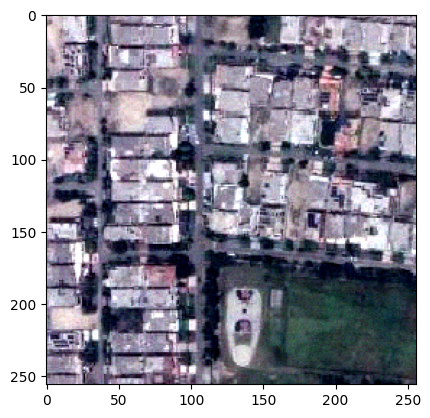

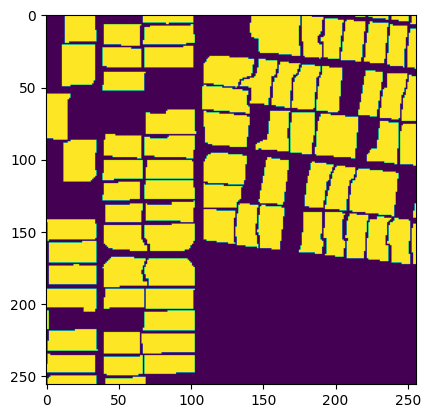

In [10]:
#//////////////////////// Visualize the data \\\\\\\\\\\\\\\\\\\\\\\\
imgs_dir = os.path.join(data_dir, 'images')
msks_dir = os.path.join(data_dir, 'masks')

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = Dataset(
    imgs_dir, 
    msks_dir,
    #contr_dir,
    classes=CLASSES,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
)

image, mask, _ = dataset[1]
image = denormalize(np.transpose(image,(1,2,0)))
print(mask.dtype)
print(image.shape)
print(mask.shape)
plt.imshow(image)
plt.show()
plt.imshow(mask)
plt.show()

In [17]:
#//////////////////////// Training \\\\\\\\\\\\\\\\\\\\\\\\
ct_train = False
overwrite = False

images_train_dir = os.path.join(data_dir, 'images')
buildings_train_dir = os.path.join(data_dir, 'masks')

images_test_dir = os.path.join(data_dir, 'test_images')
buildings_test_dir = os.path.join(data_dir, 'test_masks')

if ct_train:
    assert os.path.exists(os.path.join(output_dir,'best_model.h5')), "Model not found at path: {}".format(output_dir)
    model = torch.load(os.path.join(output_dir,'best_model.h5'), map_location=DEVICE)
    print('Loaded pre-trained DeepLabV3+ model!')
else:
    if os.path.exists(os.path.join(output_dir,'best_model.h5')):
        assert (overwrite), "Path already exists, cannot over write. Please set the overwrite flag to high,\
        if you want to overwrite"
        print("Warining Model path {} already exists, overwriting it".format(output_dir))
    else:
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
    
model.to(DEVICE)
# Dataset for train images
train_dataset = Dataset(
    images_train_dir,
    buildings_train_dir,
    classes=CLASSES,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
)

# Dataset for validation images
valid_dataset = Dataset(
    images_test_dir,
    buildings_test_dir,
    classes=CLASSES,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
)

threshold = 0.5 #Threshold for computation of tp,fp,fn,tn


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE_VAL, shuffle=False, num_workers=0)

best_iou_score = 0.0
break_value = 3

if ct_train:
    f = open(os.path.join(output_dir, 'train_logs.txt'), "r")
    lines = f.readlines()
    f.close()
    if len(lines) > 1:
        start = int(lines[-1].split(' ')[0]) + 1
    else:
        start =0
    
    print("Starting from Epoch {}".format(start))
else:
    with open(os.path.join(output_dir, 'train_logs.txt'), "w") as f:
        f.write("Epoch #: Logs" + "\n")

    with open(os.path.join(output_dir, 'valid_logs.txt'), "w") as f:
        f.write("Epoch #: Logs" + "\n")
    
    start = 0


print("Total Epochs: {}".format(EPOCHS))
for i in range(start, EPOCHS):
    # Perform training & validation
    print('\nEpoch: {}'.format(i))
    model.train()
    train_logs = {}
    loss_meter = np.array([])
    metrics_meters = {name : np.array([]) for name, func in metrics.items()}
    verbose = True
    

    with tqdm(train_loader) as iterator:
        for x, y, _ in iterator:
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            y_pred = model.forward(x)
            loss_Val = loss(y_pred, y)
            loss_Val.backward()
            optimizer.step()
            # update loss logs
            loss_value = loss_Val.cpu().detach().numpy()
            loss_meter = np.append(loss_meter, loss_value)
            loss_logs = {"LOSS": np.mean(loss_meter)}
            train_logs.update(loss_logs)
            y = torch.squeeze(y)

            # update metrics logs
            for name, metric_fn in metrics.items():
                metric_value = metric_fn(torch.argmax(y_pred, dim=1), y).numpy()
                metrics_meter = metrics_meters[name]
                metrics_meters[name] = np.append(metrics_meter, metric_value)

            metrics_logs = {name: np.mean(values) for name, values in metrics_meters.items()}
            train_logs.update(metrics_logs)

            if verbose:
                str_logs = ['{} - {:.4}'.format(k, v) for k, v in train_logs.items()]
                s = ', '.join(str_logs)
                iterator.set_postfix_str(s)

    torch.save(model, os.path.join(output_dir, 'best_model.h5'))
    
    with open(os.path.join(output_dir, 'train_logs.txt'), 'a') as f:
        f.write("{} : {}".format(i, str(train_logs)) + "\n")

    model.eval()
    valid_logs = {}
    loss_meter = np.array([])
    metrics_meters = {name : np.array([]) for name, func in metrics.items()}
    verbose = True

    with tqdm(valid_loader, desc="Valid", file=sys.stdout, disable=not verbose) as iterator:
        for x, y, _ in iterator:
            x, y = x.to(DEVICE), y.to(DEVICE)
            with torch.no_grad():
                y_pred = model.forward(x)
                loss_Val = loss(y_pred, y)

            # update loss logs
            loss_value = loss_Val.cpu().detach().numpy()
            loss_meter = np.append(loss_meter, loss_value)
            loss_logs = {"LOSS": np.mean(loss_meter)}
            valid_logs.update(loss_logs)

            y = torch.squeeze(y)

            # update metrics logs
            for name,metric_fn in metrics.items():
                metric_value = metric_fn(torch.argmax(y_pred, dim=1), y).numpy()
                metrics_meter = metrics_meters[name]
                metrics_meters[name] = np.append(metrics_meter, metric_value)

            metrics_logs = {name: np.mean(vals) for name, vals in metrics_meters.items()}
            valid_logs.update(metrics_logs)

            if verbose:
                str_logs = ['{} - {:.4}'.format(k, v) for k, v in valid_logs.items()]
                s = ', '.join(str_logs)
                iterator.set_postfix_str(s)

    with open(os.path.join(output_dir, 'valid_logs.txt'), 'a') as f:
        f.write("{} : {}".format(i, str(valid_logs)) + "\n")

Warining Model path D:\LUMS_RA\Models\TryRun already exists, overwriting it
Total Epochs: 100

Epoch: 0


  1%|▍                                            | 4/410 [00:30<51:42,  7.64s/it, LOSS - 0.255, IOU Score - 7.306e-13]


Valid:   5%|█▊                                    | 11/224 [00:03<01:13,  2.92it/s, LOSS - 0.2776, IOU Score - 0.09091]


KeyboardInterrupt: 

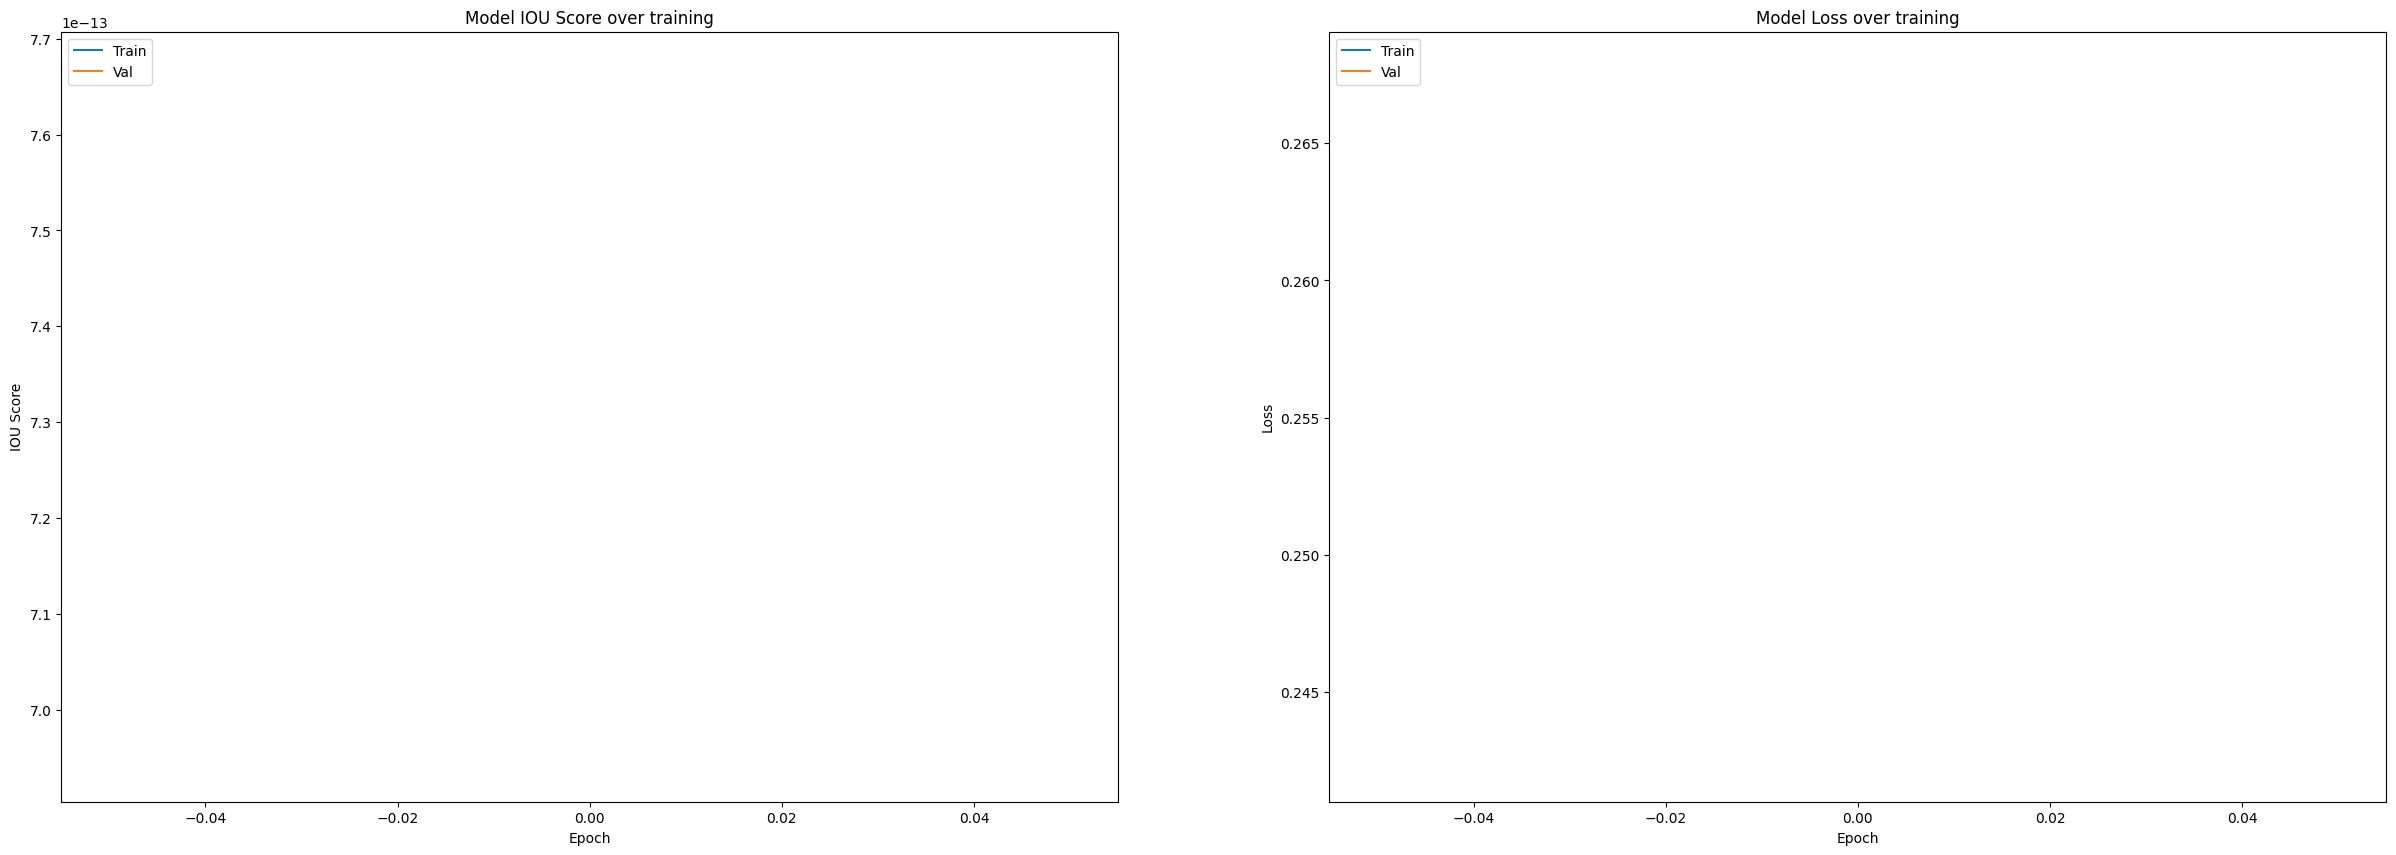

In [18]:
#//////////////////////// Plot the train/valid logs \\\\\\\\\\\\\\\\\\\\\\\\
f = open(os.path.join(output_dir, 'train_logs.txt'))
lines_tr = f.readlines()
f.close()

f = open(os.path.join(output_dir, 'train_logs.txt'))
lines_tr = f.readlines()
f.close()
lines_tr = [line for i,line in enumerate(lines_tr) if i > 0]

f = open(os.path.join(output_dir, 'valid_logs.txt'))
lines_val = f.readlines()
f.close()
lines_val = [line for i,line in enumerate(lines_val) if i > 0]

scores_tr = [json.loads(line[4:].replace("\'", "\"")) for line in lines_tr]
scores_val = [json.loads(line[4:].replace("\'", "\"")) for line in lines_val]

iou_train = [float(dic['IOU Score']) for dic in scores_tr]
iou_val = [float(dic['IOU Score']) for dic in scores_val]

loss_train = [float(dic['LOSS']) for dic in scores_tr]
loss_val = [float(dic['LOSS']) for dic in scores_val]

plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
plt.plot(iou_train)
plt.plot(iou_val)
plt.title("Model IOU Score over training")
plt.xlabel('Epoch')
plt.ylabel('IOU Score')
plt.legend(['Train', 'Val'], loc = 'upper left')

plt.subplot(1,2,2)
plt.plot(loss_train)
plt.plot(loss_val)
plt.title("Model Loss over training")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc = 'upper left')
plt.show()

(256, 256)
(256, 256)
(256, 256, 1)
(256, 256, 3)


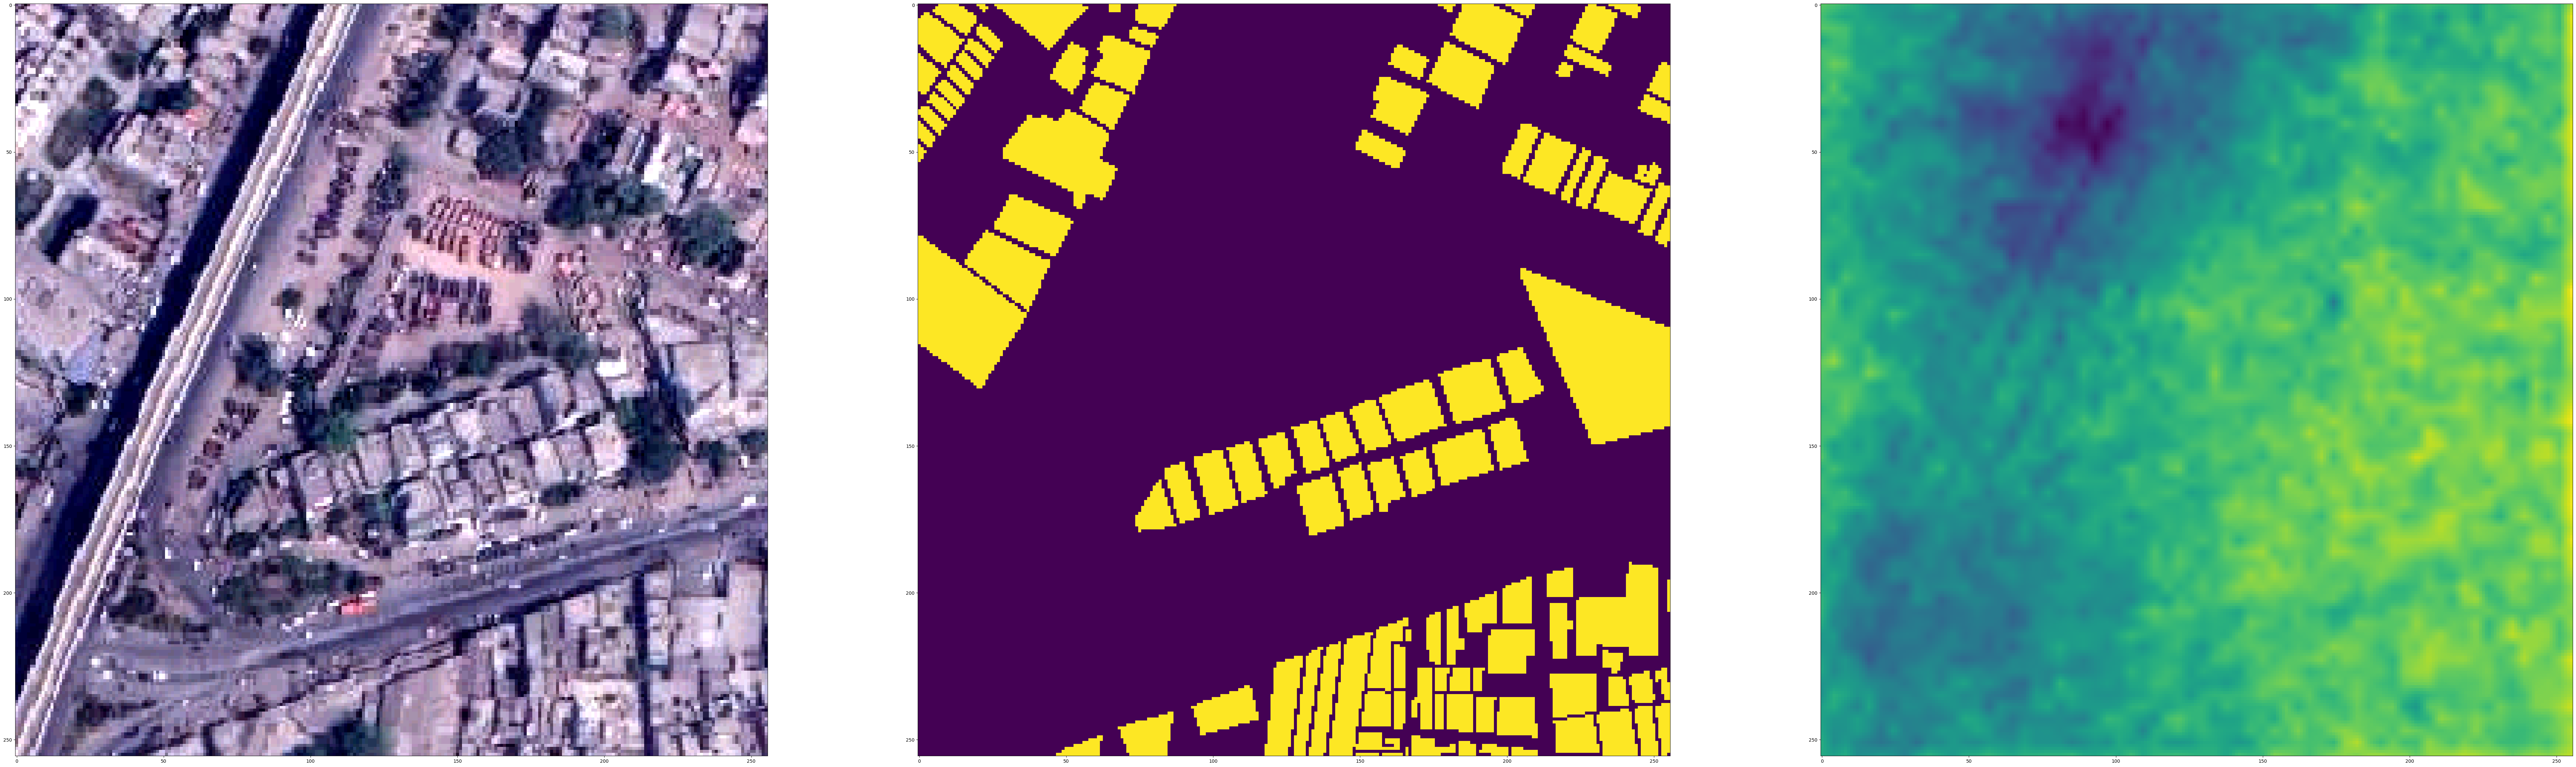

In [19]:
#//////////////////////// Visualize Results on an image from Test Set \\\\\\\\\\\\\\\\\\\\\\\\
images_dir = os.path.join(data_dir, 'test_images')
masks_dir = os.path.join(data_dir, 'test_masks')

# Set device: `cuda` or `cpu`   
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_dataset = Dataset(
    images_dir,
    masks_dir,
    classes=CLASSES,
    #augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
)

# load best weights
best_model = torch.load(os.path.join(output_dir,'best_model.h5'), map_location=DEVICE)
image, gt_mask, _ = test_dataset[0]
#gt_mask = np.transpose(gt_mask,(1,2,0))

x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
#image = image.squeeze()
image = np.transpose(image,(1,2,0))

best_model.eval()
with torch.no_grad():
    pred_mask = best_model(x_tensor)
pr_mask = pred_mask.squeeze()
pr_mask = pr_mask.detach().squeeze().cpu().numpy()
pr_mask = np.argmax(pr_mask, axis=0)

pr_mask = pred_mask.squeeze()
pr_mask = pr_mask.detach().squeeze().cpu().numpy()
print(pr_mask.shape)
pr_mask = pr_mask

#print(pr_mask.shape)
#pr_mask = np.transpose(pr_mask,(1,2,0))

print(pr_mask.shape)
print(gt_mask.shape)
print(image.shape)


#print(Dataset.colors)
plt.figure(figsize=(100,100))
plt.subplot(1,3,1)
plt.imshow(denormalize(image.squeeze()), interpolation='none')
plt.subplot(1,3,2)
plt.imshow(gt_mask, interpolation='none')
plt.subplot(1,3,3)
plt.imshow(pr_mask, interpolation='none')
plt.show()

In [20]:
#//////////////////////// Evaluate on Images \\\\\\\\\\\\\\\\\\\\\\\\

imgs_dir = os.path.join(data_dir, 'images') # Input the path to images
pred_dir = os.path.join(data_dir, 'predictions') # The path where outputs are saved
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# load best weights
model = torch.load(os.path.join(output_dir,'best_model.h5'), map_location=DEVICE)
model.eval()
dataset = Dataset(
    imgs_dir, 
    imgs_dir, 
    classes=CLASSES, 
    preprocessing=get_preprocessing(preprocessing_fn),
)
i = 0
with tqdm(dataset, file=sys.stdout) as iterator:
    for it in iterator:
        image, _,f_name = dataset[i]
        x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
        image = image.squeeze()
        image = np.transpose(image,(1,2,0))
        pred_mask = model(x_tensor)
        pr_mask = pred_mask.round().squeeze()
        pr_mask = pr_mask.detach().squeeze().cpu().numpy()

        if mode == smp.losses.constants.BINARY_MODE:
            pr_mask = np.expand_dims(pr_mask, 0)

        #print(pr_mask.shape)
        pr_mask = np.transpose(pr_mask,(1,2,0))
        pr_img = np.zeros((pr_mask.shape[0],pr_mask.shape[1],3))
        for j in range(pr_mask.shape[2]):
            pr_img = pr_img+ MasktoRGB(pr_mask[...,j],Dataset.colors[j])

        #f_name = "{}.png".format(i+1)
        save_path = os.path.join(pred_dir,f_name)
        plt.imsave(save_path,pr_img.astype(np.uint8))
        i = i+1
        #print("Output for Image: {} has been saved!".format(f_name))

  1%|▍                                                                               | 20/3274 [00:06<18:47,  2.89it/s]


KeyboardInterrupt: 

In [92]:
#//////////////////////// Evaluate on Large Tiff File(s) \\\\\\\\\\\\\\\\\\\\\\\\

def save_as_csv(out_path, contours):
    out_path = os.path.join(out_path, 'polygons.csv')
    fw = open(out_path, 'w')
    fw.write("id,Geometry\n")
    for j, contour in enumerate(contours):
        polygon_str = re.sub(r"[\[\]]", '', ",".join(map(str, contour)))
        fw.write("%s,%d,\"POLYGON ((%s))\"\n" % (j, polygon_str))
    fw.close()


def assign_geocoords(contours, img_path, y_flip=True):
    # img_path = get_respond_img(imgs_dir,npy_file)
    dataset = rasterio.open(img_path)

    x_min_coord = dataset.bounds[0]  # left edge
    x_max_coord = dataset.bounds[2]  # right edge
    y_min_coord = dataset.bounds[1]  # bottom edge
    y_max_coord = dataset.bounds[3]  # top edge

    y_img_size, x_img_size = dataset.read(1).shape
    dataset.close()

    for it in range(len(contours)):
        contour = contours[it]

        x = (contour[:, 0])
        y = (contour[:, 1])
        if (y_flip):
            y = y_img_size - (y)

        geo_x = x_min_coord + (x / x_img_size) * (x_max_coord - x_min_coord)
        geo_y = y_min_coord + (y / y_img_size) * (y_max_coord - y_min_coord)

        contours[it] = np.vstack((geo_x, geo_y)).T

    return contours


input_imgs = r"D:\LUMS_RA\Data\Google_Earth_Images_Downloader\DHA\19\12_09_2022.tif"
model_path = r"D:\LUMS_RA\Models\Segmentation\trained_model\DeepLabV3+\Combined_Images"
output_dir = "D:/Temp_Out"

ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'

target_size = (320, 320)
padding_pixels = (32, 32)
padding_value = 0
downsampling_factor = 1
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PIX_VALUE_MAX = 255    # The max data value we have
PIX_VALUE_MAX_REQ = 255 # The max data value we need
print(os.path.join(model_path, 'best_model.h5'))
model = torch.load(os.path.join(model_path, 'best_model.h5'), map_location=DEVICE)
model.eval()
imgs = [file for file in glob.glob(input_imgs) if file.endswith('.tif')]
print(imgs)
assert len(imgs) > 0, "The number of images equal to zero"

print("Running on {} images".format(len(imgs)))# using {} parallel processes".format(len(imgs), num_processes))

for img_path in imgs:
    file_name = os.path.split(img_path)[-1].split('.')[0]
    print("Running for {}".format(file_name))

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    save_path = os.path.join(output_dir, file_name + "_preds.npy")
    img = np.transpose(rasterio.open(img_path).read(), (1, 2, 0))
    print("Actual Image Size: {}".format(img.shape))

    #Define k_x, k_y to define 'useful' portion, since we are taking patches with overlapping area.
    k_y = target_size[0] - 2 * padding_pixels[0]
    k_x = target_size[1] - 2 * padding_pixels[1]

    # First padding: To make divisible by k
    cols = (math.ceil(img.shape[0]/k_y))
    rows = (math.ceil(img.shape[1]/k_x))

    pad_bottom = cols*k_y - img.shape[0]   #pixels to add in y direction
    pad_right = rows*k_x - img.shape[1]    #pixels to add in x direction
    if pad_bottom > 0 or pad_right > 0:
        print("Running cv2 padding..")
        img = cv2.copyMakeBorder(img, 0, pad_bottom, 0, pad_right, cv2.BORDER_CONSTANT, value=padding_value)
    print("Image Size after making divisible by ({}, {}): {}".format(k_x, k_y, img.shape))

    output_image = np.zeros((int(img.shape[0]*downsampling_factor), int(img.shape[1]*downsampling_factor)), dtype=np.uint8) * 255
    print("Size of output image after downsampling factor of {}: {}".format(downsampling_factor, output_image.shape))

    # Second Padding: To add boundary padding pixels
    img = cv2.copyMakeBorder(img, padding_pixels[0], padding_pixels[0], padding_pixels[1], 
                             padding_pixels[1], cv2.BORDER_CONSTANT, value=padding_value)
    print("Image Size after adding ({}, {}) boundary pixels: {}".format(padding_pixels[0], padding_pixels[0], img.shape))

    # Load pre-processing function
    preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
    preprocessing = get_preprocessing(preprocessing_fn)

    total_patches = rows*cols
    print("Total {} patches for the given image {}".format(rows*cols, file_name))
    for y_idx in range(cols):
        y1 = y_idx*k_y + padding_pixels[0]
        y2 = y1 + k_y
        for x_idx in range(rows):
            x1 = x_idx*k_x + padding_pixels[1]
            x2 = x1 + k_x
            patch_number = y_idx*rows + x_idx + 1

            img_crop = img[y1-padding_pixels[0]: y2 + padding_pixels[0], x1 - padding_pixels[1]: x2 + padding_pixels[1]]
            print("Patch {} of {}: [{}:{}, {}:{}]".format(patch_number, total_patches, y1-padding_pixels[0],
                                                          y2 + padding_pixels[0], x1 - padding_pixels[1],
                                                          x2 + padding_pixels[1]), end =" ")
            
            img_crop = ((img_crop/PIX_VALUE_MAX)*(PIX_VALUE_MAX_REQ)).astype(np.uint8)
            sample = preprocessing(image=img_crop)
            image = cv2.resize(sample['image'], 
                               (int(downsampling_factor * target_size[0]),
                                int(downsampling_factor * target_size[1])),
                               interpolation = cv2.INTER_AREA)
            x_tensor = torch.Tensor(image).permute(2, 0, 1).to(DEVICE).unsqueeze(0)
            with torch.no_grad():
                pred_mask = model(x_tensor)
            pr_mask = pred_mask.squeeze()
            pr_mask = pr_mask.detach().squeeze().cpu().numpy().round()

            patch = pr_mask[int(downsampling_factor * padding_pixels[0]) : int(downsampling_factor * (target_size[0] - padding_pixels[0])),
                            int(downsampling_factor * padding_pixels[1]) : int(downsampling_factor * (target_size[1] - padding_pixels[1]))]
            output_image[int(downsampling_factor*(y_idx*k_y)): int(downsampling_factor*(y_idx*k_y + k_y)),
                           int(downsampling_factor*(x_idx*k_x)): int(downsampling_factor*(x_idx*k_x + k_x))] = patch
            print("..... Done!")


    output_image = output_image[:output_image.shape[0] - int(downsampling_factor * pad_bottom),
                                :output_image.shape[1] - int(downsampling_factor * pad_right)]
    print("Final shape of downsampled output image: {}".format(output_image.shape))

    np.save(save_path, output_image)
    img = np.load(save_path)
    labels = measure.label(img, connectivity=2, background=0).astype('uint16')
    polygon_gen = shapes(labels, labels > 0)
    geoms_np = []
    ct = 0
    for polygon, value in polygon_gen:
        ct = ct + 1
        p = shape(polygon)
        if p.area >= 0:
            p = p.simplify(tolerance=0.5)
            try:
                p = np.array(p.boundary.xy, dtype='int32').T
            except:
                p = np.array(p.boundary[0].xy, dtype='int32').T
            geoms_np.append(p)
    geo_poly = (assign_geocoords(geoms_np, img_path))
    save_as_csv(output_dir, geo_poly)
    print("Completed!")
    

D:\LUMS_RA\Models\Segmentation\trained_model\DeepLabV3+\Combined_Images\best_model.h5
['D:\\LUMS_RA\\Data\\Google_Earth_Images_Downloader\\DHA\\19\\12_09_2022.tif']
Running on 1 images
Running for 12_09_2022


KeyboardInterrupt: 